This notebook is a re-factoring of `duration-prediction_experiment.ipynb`. Each step is put together in a cell.
`df1 is used for training`, while `df2 is used for validation`.

In [1]:
!pip install pyarrow

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pickle

In [3]:
## all preprocessing
def read_data(filename):
    
    df1 = pd.read_parquet(filename)

    # select samples of trip_type==2 (dispatched)
    df1 = df1[df1["trip_type"]==2]

    # duration = drop off time - pick up time
    df1.loc[:,"duration"] = df1.loc[:,"lpep_dropoff_datetime"] - df1.loc[:,"lpep_pickup_datetime"]

    # reset index
    df1 = df1.reset_index(drop=True)

    # convert duration to seconds and then minutes
    df1["duration"] = df1["duration"].apply(lambda x:x.total_seconds()/60)

    # filter the dataset based on duration (in mins)
    df1 = df1[(df1["duration"]>0)&(df1["duration"]<=60)]

    # use the pick up location, drop off location and trip distance to predict the ride duration
    clean_df = df1[["PULocationID", "DOLocationID", "trip_distance", "duration"]]
    
    return clean_df

In [4]:
train_df = read_data("./data/green_tripdata_2021-01.parquet")
train_df.shape

(1209, 4)

In [5]:
test_df = read_data("./data/green_tripdata_2021-02.parquet")
test_df.shape

(1060, 4)

In [6]:
# one hot encoding data transformation
def ohe_transform_data(df, categorical, non_categorical):
    
    ohe = OneHotEncoder()
    cat = ohe.fit_transform(df[categorical]).toarray()

    col_names = ohe.get_feature_names_out(categorical)

    cat_df = pd.DataFrame(cat, columns=col_names)

    df = pd.concat([cat_df, df[non_categorical]], axis=1)

    df.dropna(inplace=True)
    
    return df

In [7]:
categorical = ["PULocationID", "DOLocationID"]
non_categorical = ["trip_distance", "duration"]

In [10]:
train = ohe_transform_data(train_df, categorical, non_categorical)
test = ohe_transform_data(test_df, categorical, non_categorical)

In [11]:
X_train = train_df.loc[:,:"duration"]
y_train = train_df.loc[:,"duration"]

X_val = test_df.loc[:,:"duration"]
y_val = test_df.loc[:,"duration"]

print(f"Len of Train: {len(X_train)}")
print(f"Len of Valid: {len(X_val)}")

Len of Train: 1209
Len of Valid: 1060


In [12]:
# model fitting
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict on same train data to see how the model is fitting
y_pred = lr.predict(X_val)

# model evaluation
mean_squared_error(y_pred, y_val, squared=False)

4.829461139727947e-15

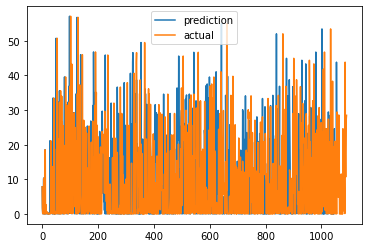

In [13]:
plt.plot(y_pred, label="prediction")
plt.plot(y_val, label="actual")
plt.legend()
plt.show()

In [15]:
# save model
!mkdir models

In [16]:
!ls

data				      duration-prediction_modularised.ipynb
duration-prediction_experiment.ipynb  models


In [17]:
# dump the model and one-hot encoding object as a pickle file
with open("./models/linear_model.bin", "wb") as f_out:
    pickle.dump((ohe, lr), f_out)